# Part 6 - Pipeline with average of image for annotation

### Here we broke the main pipeline in several functions and apply a buffer

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Read in the saved camera matrix and distortion coefficients
# These are the arrays we calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/camera_cal_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in the saved perspective transformation matrices
# These are the arrays we calculated using cv2.getPerspectiveTransform()
dist_pickle = pickle.load( open( "camera_cal/perspective_trans_matrices.p", "rb" ) )
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]

### Define Functions

In [2]:
def filter_WhiteYellow(image):
    """
    Filter the image, showing only a range of white and yellow
    """
    # Filter White
    threshold = 200 
    high_threshold = np.array([255, 255, 255]) #Bright white
    low_threshold = np.array([threshold, threshold, threshold]) #Soft White
    mask = cv2.inRange(image, low_threshold, high_threshold)
    white_img = cv2.bitwise_and(image, image, mask=mask)

    # Filter Yellow
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #Changing Color-space, HSV is better for object detection
    #For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. 
    high_threshold = np.array([110,255,255]) #Bright Yellow
    low_threshold = np.array([50,50,50]) #Soft Yellow   
    mask = cv2.inRange(hsv_img, low_threshold, high_threshold)
    yellow_img = cv2.bitwise_and(image, image, mask=mask)

    # Combine the two above images
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

def thresholding(image, M):
    """
    Apply Yellow and White Filter and create binary image
    """
    img_size = (image.shape[1], image.shape[0])
    # Filter white and Yellow to make it easier for more accurate Canny detection
    filtered_img = filter_WhiteYellow(image)
    # Convert image to gray scale
    gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
    # Create binary based on detected pixels
    binary_threshold = np.zeros_like(gray)
    binary_threshold[(gray > 0)] = 1
    # Warp the image
    warped = cv2.warpPerspective(binary_threshold, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, binary_threshold


def mag_thresh(image, sobel_kernel=5, mag_thresh=(50, 200)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary


def thresholding2(img, M, sx_thresh=(20, 100)):
    img_size = (img.shape[1], img.shape[0])
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    binary_output = mag_thresh(img, sobel_kernel=5, mag_thresh=(30, 100))

    # Filter white and Yellow to make it easier for more accurate Canny detection
    filtered_img = filter_WhiteYellow(img)
    # Convert image to gray scale
    gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
    binary_output2 = np.zeros_like(gray)
    binary_output2[(gray > 0)] = 1

    binary_threshold = np.zeros_like(binary_output)
    binary_threshold[((binary_output2 == 1) | (binary_output == 1))] = 1
    
    warped = cv2.warpPerspective(binary_threshold, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, binary_output, binary_output2, binary_threshold


In [3]:
class Line():
    '''
    Keeps track of line.
    '''
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # x values of the last n fits of the line
        self.recent_xfitted = []

        # average x values of the fitted line over the last n iterations
        self.bestx = None

        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None

        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]

        # radius of curvature of the line in some units
        self.radius_of_curvature = None

        # distance in meters of vehicle center from the line
        self.line_base_pos = None

        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')

        # x values for detected line pixels
        self.all_x = None

        # y values for detected line pixels
        self.all_y = None

In [15]:
def sliding_window(binary_warped):
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), color=(0,255,0), thickness=2) # Green
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), color=(0,255,0), thickness=2) # Green
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print(left_fit) # to measure tolerances
    
    # Stash away polynomials
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[ploty.astype('int'),left_fitx.astype('int')] = [0, 255, 255]
    out_img[ploty.astype('int'),right_fitx.astype('int')] = [0, 255, 255]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)

    # Calculate radii of curvature in meters
    y_eval = np.max(ploty)  # Where radius of curvature is measured
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Stash away the curvatures  
    left_line.radius_of_curvature = left_curverad  
    right_line.radius_of_curvature = right_curverad
    
    return left_fit, right_fit, left_curverad, right_curverad, out_img

    
    
def non_sliding(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
        & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
        & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2) 
    except:
        return left_line.current_fit, right_line.current_fit, left_line.radius_of_curvature, right_line.radius_of_curvature, None
    
    else:
        # Check difference in fit coefficients between last and new fits  
        left_line.diffs = left_line.current_fit - left_fit
        right_line.diffs = right_line.current_fit - right_fit
        if (left_line.diffs[0]>0.001 or left_line.diffs[1]>0.4 or left_line.diffs[2]>150):
            return left_line.current_fit, right_line.current_fit, left_line.radius_of_curvature, right_line.radius_of_curvature, None
        #print(left_line.diffs)
        if (right_line.diffs[0]>0.001 or right_line.diffs[1]>0.4 or right_line.diffs[2]>150):
            return left_line.current_fit, right_line.current_fit, left_line.radius_of_curvature, right_line.radius_of_curvature, None
        #print(right_line.diffs)
        
        # Stash away polynomials
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Calculate radii of curvature in meters
        y_eval = np.max(ploty)  # Where radius of curvature is measured
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])     

        # Stash away the curvatures  
        left_line.radius_of_curvature = left_curverad  
        right_line.radius_of_curvature = right_curverad

        return left_fit, right_fit, left_curverad, right_curverad, None


In [5]:
def draw_lane(undistorted, binary_warped, left_fit, right_fit, left_curverad, right_curverad):
    
    # Create an image to draw the lines on
    warped_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warped = np.dstack((warped_zero, warped_zero, warped_zero))    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]   
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    midpoint = np.int(undistorted.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    offset = (midpoint - middle_of_lane) * xm_per_pix

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warped, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = (undistorted.shape[1], undistorted.shape[0])
    unwarped = cv2.warpPerspective(color_warped, Minv, img_size, flags=cv2.INTER_LINEAR)

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, unwarped, 0.3, 0)
    radius = np.mean([left_curverad, right_curverad])

    # Add radius and offset calculations to top of video
    cv2.putText(result,"L. Lane Radius: " + "{:0.2f}".format(left_curverad/1000) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"R. Lane Radius: " + "{:0.2f}".format(right_curverad/1000) + 'km', org=(50,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)

    return result

In [6]:
# Enlarge Inline Pictures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = "14, 8" # or  whatever you want

In [7]:
import glob

# Make a list of images
images = glob.glob('test_images/test*.jpg')
images.sort()

In [8]:
images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

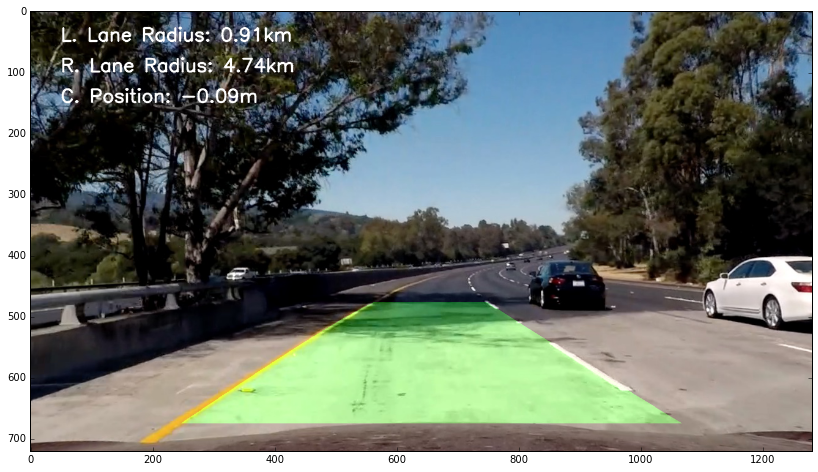

In [9]:
left_line = Line()
right_line = Line()
detected = False

img = cv2.imread(images[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#binary_warped = thresholding2(undistorted, M)
binary_warped, binary_output2 = thresholding(undistorted, M)

if not detected:
    left_fit, right_fit, left_curverad, right_curverad, _ = sliding_window(binary_warped)
    detected = True
else:
    left_fit, right_fit, left_curverad, right_curverad, _ = non_sliding(binary_warped, left_fit, right_fit)

result = draw_lane(undistorted, binary_warped, left_fit, right_fit, left_curverad, right_curverad)

plt.imshow(result)


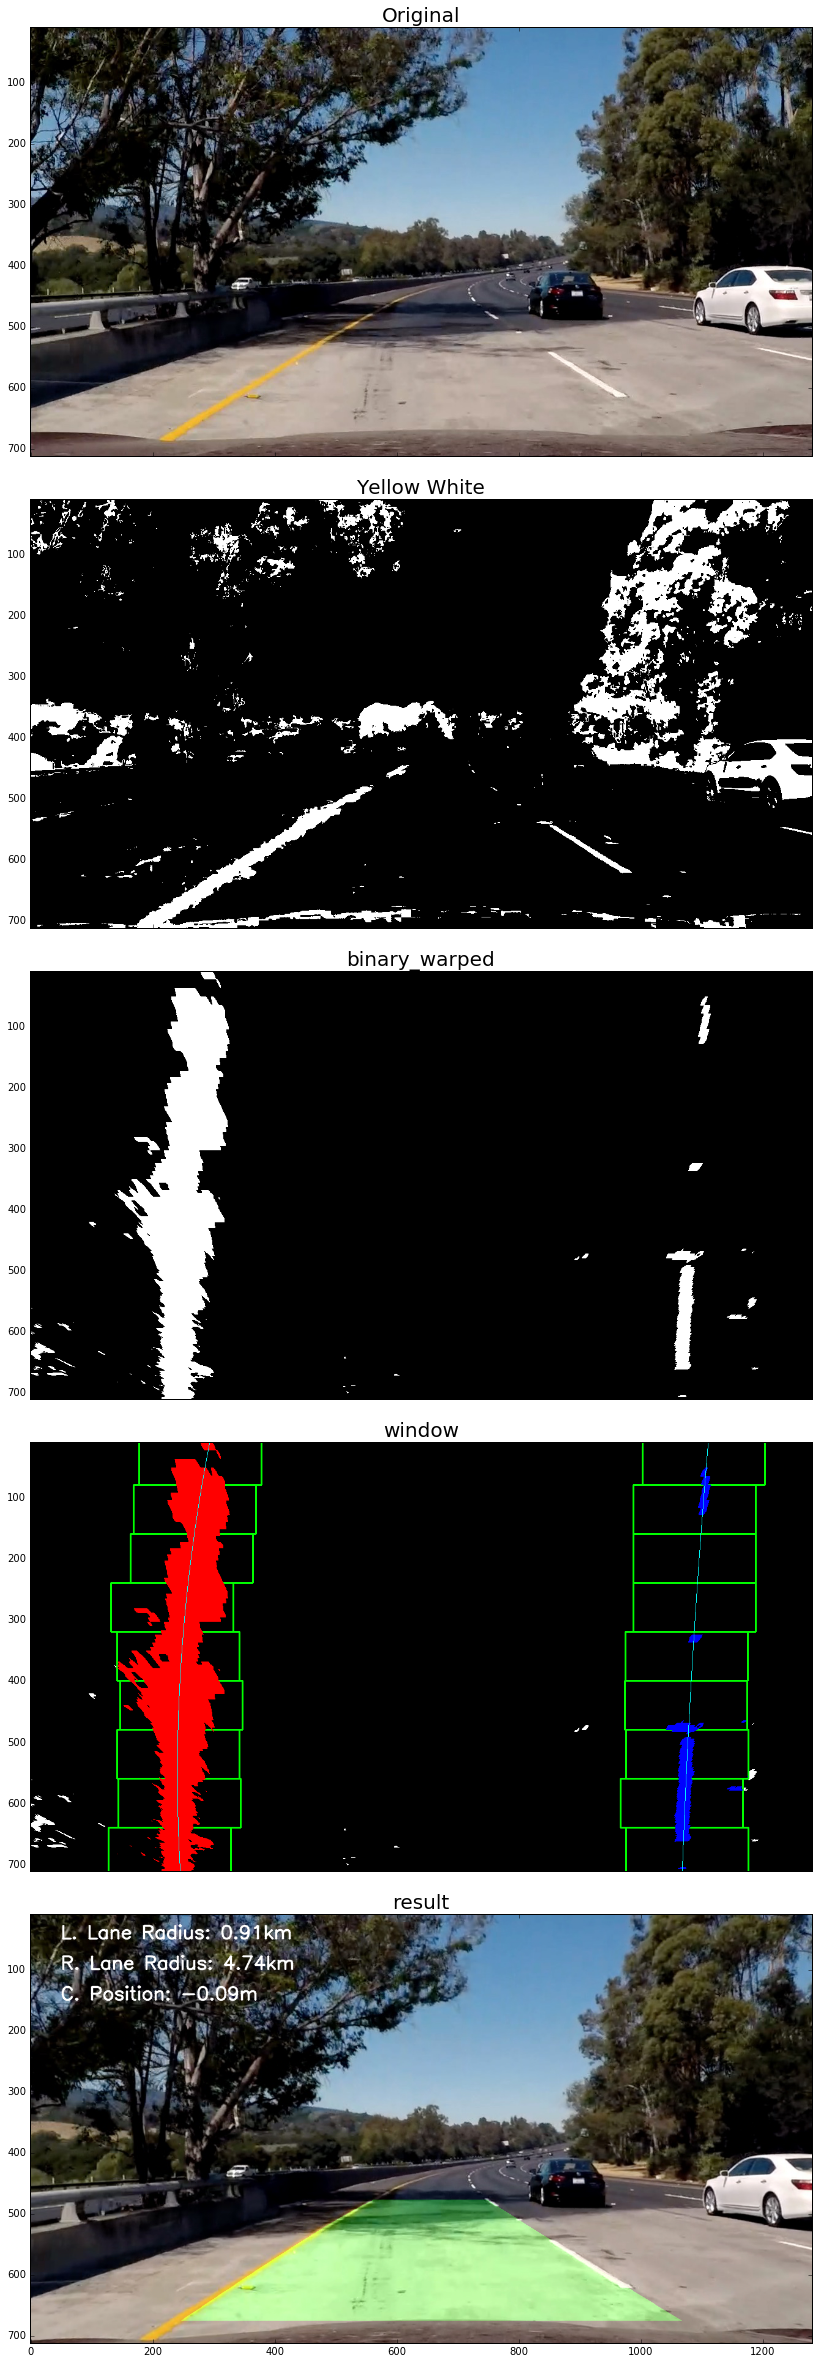

In [16]:
left_line = Line()
right_line = Line()
detected = False

img = cv2.imread(images[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
binary_warped, binary_output2 = thresholding(undistorted, M)

if not detected:
    left_fit, right_fit, left_curverad, right_curverad, outimg = sliding_window(binary_warped)
    detected = True
else:
    left_fit, right_fit, left_curverad, right_curverad, _ = non_sliding(binary_warped, left_fit, right_fit)

result = draw_lane(undistorted, binary_warped, left_fit, right_fit, left_curverad, right_curverad)

# Display Images
f, axarr = plt.subplots(5, sharex=True, figsize=(14,5*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
axarr[0].imshow(img, cmap=None) 
axarr[0].set_title('Original', fontsize=20)
axarr[1].imshow(binary_output2, cmap='gray') 
axarr[1].set_title('Yellow White', fontsize=20)
axarr[2].imshow(binary_warped, cmap='gray') 
axarr[2].set_title('binary_warped', fontsize=20)
axarr[3].imshow(outimg, cmap='gray') 
axarr[3].set_title('window', fontsize=20)
axarr[4].imshow(result, cmap='gray') 
axarr[4].set_title('result', fontsize=20)

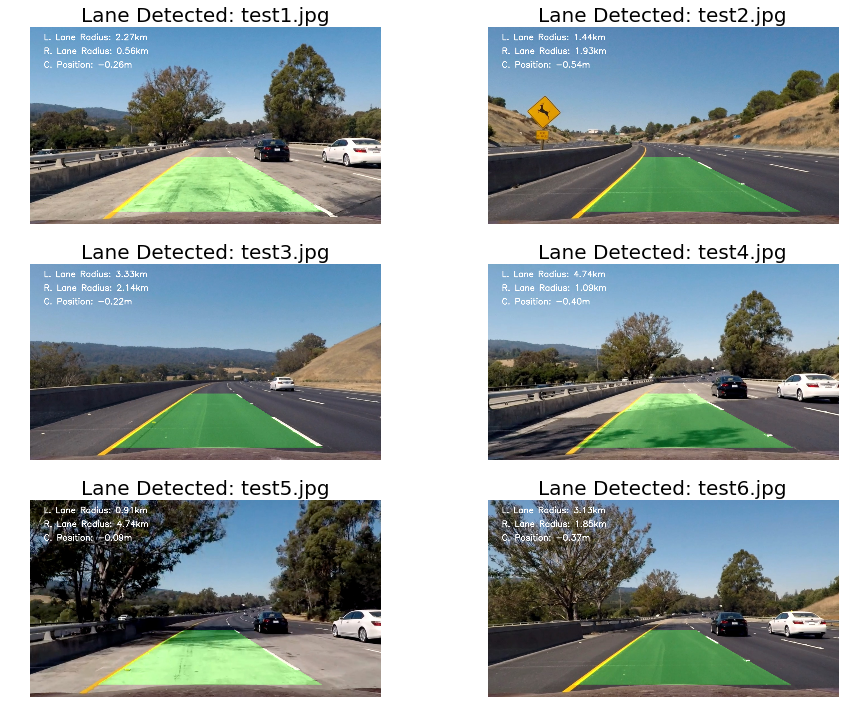

In [65]:
#  Plotting function for images
def plotImages(images, ncols=1, cmap=None, prefix_label = 'label:'):
    """
    Plot images in a subplot arrangement.
    images = python list of images full path
    ncols = numbers of columns in the image plot arrangement
    prefix_label = prefix label to show on top of images
    """
    from os.path import basename
    
    nrows = int(np.ceil(len(images) / ncols))
    scalesize = nrows*ncols
    f, axarr = plt.subplots(nrows, ncols, figsize=(8*ncols, 4*nrows))
    f.subplots_adjust(hspace=0.2, wspace=0.05)
    axarr = axarr.flatten() # iterate on plots via 1D
    
    for idx, fname in enumerate(images):
        # load image, change color space, undistort
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)
        #binary_warped = thresholding2(undistorted, M)
        binary_warped, binary_output2 = thresholding(undistorted, M)
        
        # Apply pipeline
        left_line = Line()
        right_line = Line()
        left_fit, right_fit, left_curverad, right_curverad, _ = sliding_window(binary_warped)
        result = draw_lane(undistorted, binary_warped, left_fit, right_fit, left_curverad, right_curverad)
        
        axarr[idx].axis('off')
        axarr[idx].imshow(result, cmap=cmap)
        axarr[idx].set_title(prefix_label + ' ' + basename(images[idx]), fontsize=20)

        
plotImages(images, ncols=2, cmap='gray', prefix_label = 'Lane Detected:')

### Teste on videos

In [9]:
from collections import deque

In [10]:
def get_processor(nbins=10):
    bins = nbins
    l_params = deque(maxlen=bins)
    r_params = deque(maxlen=bins)
    l_radius = deque(maxlen=bins)
    r_radius = deque(maxlen=bins)
    weights = np.arange(1,bins+1)/bins
    def process_image(img):
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)
        #binary_warped = thresholding2(undistorted, M)
        binary_warped, binary_output2 = thresholding(undistorted, M)

        if len(l_params)==0:
            left_fit, right_fit, left_curverad, right_curverad, _ = sliding_window(binary_warped)
        else:
            left_fit, right_fit, left_curverad, right_curverad, _ = non_sliding(binary_warped,
                                                                    np.average(l_params,0,weights[-len(l_params):]),
                                                                    np.average(r_params,0,weights[-len(l_params):]))
        
        l_params.append(left_fit)
        r_params.append(right_fit)
        l_radius.append(left_curverad)
        r_radius.append(right_curverad)
        annotated_image = draw_lane(undistorted,
                                    binary_warped,
                                    np.average(l_params,0,weights[-len(l_params):]),
                                    np.average(r_params,0,weights[-len(l_params):]),
                                    np.average(l_radius,0,weights[-len(l_params):]),
                                    np.average(r_radius,0,weights[-len(l_params):]))
        return annotated_image
    return process_image


In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [61]:
white_output = 'annotated_project_video_avg.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(get_processor(15)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video annotated_project_video_avg15_test.mp4
[MoviePy] Writing video annotated_project_video_avg15_test.mp4


100%|█████████▉| 1260/1261 [02:38<00:00,  7.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_project_video_avg15_test.mp4 

CPU times: user 6min, sys: 2.12 s, total: 6min 3s
Wall time: 2min 40s


In [62]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Try out on Challenge!

### Get frames from challenge every 10s

In [ ]:
clip = VideoFileClip("challenge_video.mp4")
clip.write_images_sequence("images%03d.jpeg", fps=10)

In [13]:
# Make a list of images
images2 = glob.glob('ChallengeFrames/images*.jpeg')
images2.sort()

### Test on images

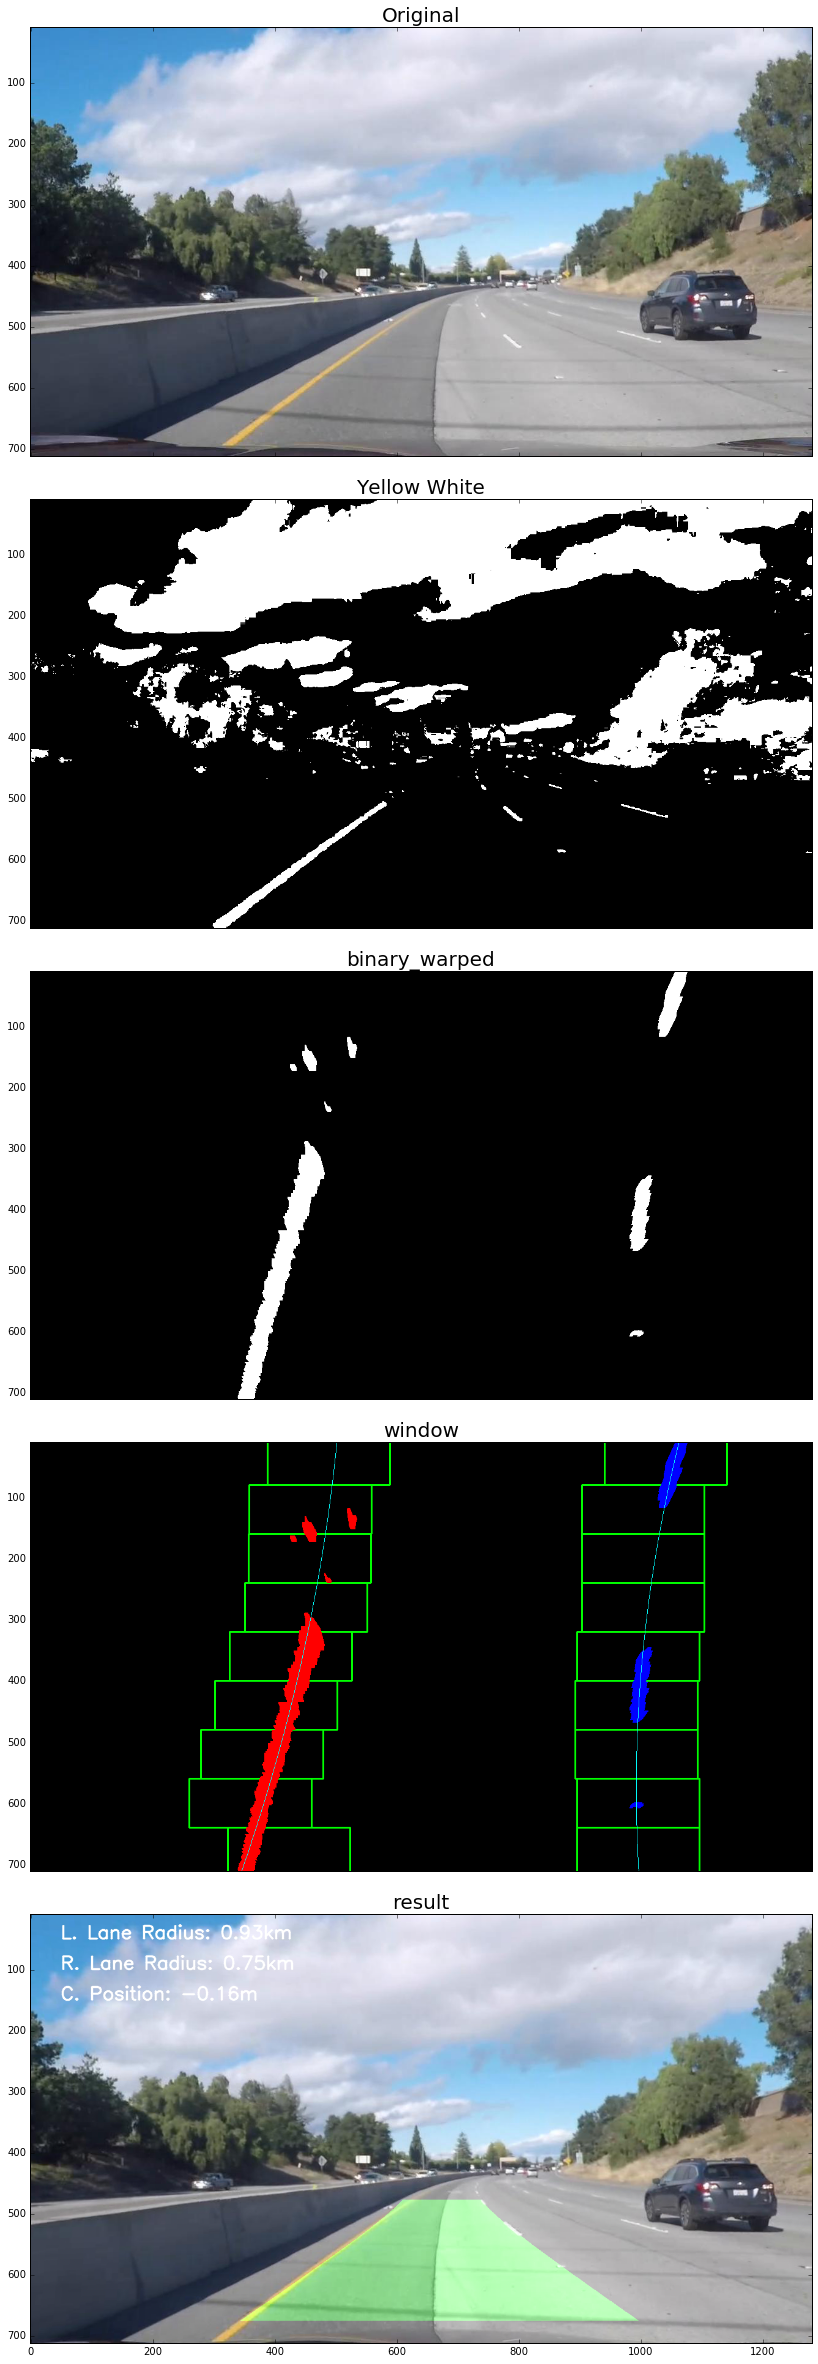

In [17]:
left_line = Line()
right_line = Line()
detected = False

img = cv2.imread(images2[54])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
binary_warped, binary_output2 = thresholding(undistorted, M)

if not detected:
    left_fit, right_fit, left_curverad, right_curverad, outimg = sliding_window(binary_warped)
    detected = True
else:
    left_fit, right_fit, left_curverad, right_curverad, _ = non_sliding(binary_warped, left_fit, right_fit)

result = draw_lane(undistorted, binary_warped, left_fit, right_fit, left_curverad, right_curverad)

# Display Images
f, axarr = plt.subplots(5, sharex=True, figsize=(14,5*8.3))
f.subplots_adjust(hspace=0.1, wspace=0.05)
axarr[0].imshow(img, cmap=None) 
axarr[0].set_title('Original', fontsize=20)
axarr[1].imshow(binary_output2, cmap='gray') 
axarr[1].set_title('Yellow White', fontsize=20)
axarr[2].imshow(binary_warped, cmap='gray') 
axarr[2].set_title('binary_warped', fontsize=20)
axarr[3].imshow(outimg, cmap='gray') 
axarr[3].set_title('window', fontsize=20)
axarr[4].imshow(result, cmap='gray') 
axarr[4].set_title('result', fontsize=20)

### Test on video

In [71]:
left_line = Line()
right_line = Line()
white_output = 'annotated_challenge_video_avg.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(get_processor(15)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video annotated_challenge_video_avg_test.mp4
[MoviePy] Writing video annotated_challenge_video_avg_test.mp4


100%|██████████| 485/485 [00:52<00:00,  9.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_challenge_video_avg_test.mp4 

CPU times: user 2min 8s, sys: 772 ms, total: 2min 9s
Wall time: 53.4 s


In [72]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))